<a href="https://colab.research.google.com/github/Leonardo-Dias-Up/Colab/blob/main/Importa%C3%A7%C3%A3o_%26_Exporta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **IMPORTAÇÃO DAS BIBLIOTECAS**

In [ ]:
!pip install geopandas
!pip install pysal
!pip install cartopy
!pip install --upgrade matplotlib
!pip install windrose
!pip install linearmodels
!pip install ipeadatapy
!!pip install python-bcb
!pip install factor_analyzer
!pip install sgs

In [2]:
!apt-get install -y fonts-liberation
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'Arial'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from libpysal import weights
import matplotlib.pyplot as plt
import seaborn as sns
import splot
from pysal.explore import esda
from pysal.model import spreg
import pysal as ps
import scipy.sparse as sp
import statsmodels.api as sm
from libpysal.weights import Queen, Rook, KNN, DistanceBand
import pysal.lib as lps
from esda.moran import Moran
import libpysal
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from PIL import Image
from linearmodels.panel import RandomEffects, PanelOLS
from scipy.stats import f_oneway
from scipy.stats import pearsonr, norm
from matplotlib.gridspec import GridSpec
import networkx as nx

In [4]:
from google.colab import auth
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import files

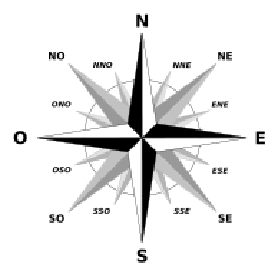

In [7]:
# Melhora a resolução da imagem
img = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/TCC/windrose.png')
dpi = 70
height, width, nbands = img.shape
figsize = width / float(dpi), height / float(dpi)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img, interpolation='nearest')

> **IMPORTAÇÃO DAS BASES DE DADOS TRATADAS - COMEX STAT**

In [8]:
# Sistema Harmonizados - Comercio Internacional
sh_6 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/sh_6.xlsx')
sh_6.head()

# Balança Comercial e Estatísticas de Comércio Exterior
cgce_ncm = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/cgce ncm.xlsx')
cgce_ncm.head()

# Exportações
export_mun = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/EXP_2020_2022.xlsx')
export_mun.head()

# Importações
import_mun = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/TCC/IMP_2020_2022.xlsx')
import_mun.head()

# Comex Stat Nomeclaturas
comex_stat = pd.merge(sh_6, cgce_ncm, on='Código NCM', how='left')
comex_stat = comex_stat.rename(columns={'Posição (SH4) - Código':'Codigo SH4'})
comex_stat['Codigo SH4'] = comex_stat['Codigo SH4'].astype(float)
comex_stat = comex_stat[['Codigo SH4', 'Código NCM', 'Descrição NCM_x', 'Código CGCE Nível 3',
                        'Descrição CGCE Nível 3',
                        'Código CGCE Nível 2', 'Descrição CGCE Nível 2',
                        'Código CGCE Nível 1', 'Descrição CGCE Nível 1']]
comex_stat.head()

,Codigo SH4,Código NCM,Descrição NCM_x,Código CGCE Nível 3,Descrição CGCE Nível 3,Código CGCE Nível 2,Descrição CGCE Nível 2,Código CGCE Nível 1,Descrição CGCE Nível 1
0,204.0,2042200,"Outras peças não desossadas de ovino, frescas ...",324,"Alimentos e bebidas elaborados, destinados pri...",32,Bens de consumo semiduráveis e não duráveis,3,BENS DE CONSUMO (BC)
1,204.0,2042300,"Carnes desossadas de ovino, frescas ou refrige...",324,"Alimentos e bebidas elaborados, destinados pri...",32,Bens de consumo semiduráveis e não duráveis,3,BENS DE CONSUMO (BC)
2,204.0,2043000,"Carcaças e meias-carcaças de cordeiro, congeladas",324,"Alimentos e bebidas elaborados, destinados pri...",32,Bens de consumo semiduráveis e não duráveis,3,BENS DE CONSUMO (BC)
3,204.0,2044100,"Carcaças e meias-carcaças de ovino, congeladas",324,"Alimentos e bebidas elaborados, destinados pri...",32,Bens de consumo semiduráveis e não duráveis,3,BENS DE CONSUMO (BC)
4,204.0,2044200,"Outras peças não desossadas de ovino, congeladas",324,"Alimentos e bebidas elaborados, destinados pri...",32,Bens de consumo semiduráveis e não duráveis,3,BENS DE CONSUMO (BC)


In [9]:
# Agrupar os dados por país e seção e calcular o total do valor FOB
df_total = export_mun.groupby(['País', 'Descrição Seção'])['Valor FOB (US$)'].sum().reset_index()
df_total.columns = ['País', 'Descrição Seção', 'Total Valor FOB']

# Mesclar os resultados ao dataframe original
export_mun = pd.merge(export_mun, df_total, on=['País', 'Descrição Seção'])
export_mun.head()

,Ano,UF do Município,Município,Codigo SH4,Descrição SH4,País,Bloco Econômico,Codigo SH2,Descrição SH2,Codigo Seção,Descrição Seção,Valor FOB (US$),Total Valor FOB
0,2020,Minas Gerais,Água Boa - MG,7117,Bijutarias,Estados Unidos,América do Norte,71,"Pérolas naturais ou cultivadas, pedras precios...",XIV,"Pérolas naturais ou cultivadas, pedras precios...",1990,181232685
1,2020,Minas Gerais,Araçuaí - MG,7103,Pedras preciosas (exceto diamantes) ou semipre...,Estados Unidos,América do Norte,71,"Pérolas naturais ou cultivadas, pedras precios...",XIV,"Pérolas naturais ou cultivadas, pedras precios...",3318,181232685
2,2020,Minas Gerais,Bela Vista de Minas - MG,7103,Pedras preciosas (exceto diamantes) ou semipre...,Estados Unidos,América do Norte,71,"Pérolas naturais ou cultivadas, pedras precios...",XIV,"Pérolas naturais ou cultivadas, pedras precios...",140795,181232685
3,2020,Minas Gerais,Belo Horizonte - MG,7102,"Diamantes, mesmo trabalhados, mas não montados...",Estados Unidos,América do Norte,71,"Pérolas naturais ou cultivadas, pedras precios...",XIV,"Pérolas naturais ou cultivadas, pedras precios...",68845,181232685
4,2020,Minas Gerais,Belo Horizonte - MG,7103,Pedras preciosas (exceto diamantes) ou semipre...,Estados Unidos,América do Norte,71,"Pérolas naturais ou cultivadas, pedras precios...",XIV,"Pérolas naturais ou cultivadas, pedras precios...",3029246,181232685


In [10]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

# Filtra os dados para excluir as observações com Valor FOB igual a zero
export_mun = export_mun[export_mun['Valor FOB (US$)'] != 0]

# Define as cores personalizadas para as seções que serão destacadas
color_sequence = px.colors.sequential.Viridis

# Cria o treemap com os valores agrupados
fig = px.treemap(export_mun,
                 path=[px.Constant("World"), 'País', 'Descrição Seção'],
                 values='Valor FOB (US$)',
                 color= 'Total Valor FOB',
                 #color_continuous_scale='viridis',
                 color_discrete_sequence=color_sequence)

# Define o template para o hover
fig.data[0].hovertemplate = '<b>%{label}</b><br> Valor FOB: %{value:,.2f}'

# Personaliza o layout
fig.update_layout(
    title='Exportação - Valor FOB por País e Descrição de Seção',
    font=dict(family='Arial', size=12),
    title_x=0.5,
    title_y=0.95
)

# Adiciona a legenda com autoria própria
fig.add_annotation(text='Fonte: Autoria Própria, 2023',
                    x=1, y=-0.15,
                    showarrow=False,
                    font=dict(size=12))

# Mostra o treemap
fig.show()

In [11]:
# Agrupar os dados por país e seção e calcular o total do valor FOB
df_total = import_mun.groupby(['País', 'Descrição Seção'])['Valor FOB (US$)'].sum().reset_index()
df_total.columns = ['País', 'Descrição Seção', 'Total Valor FOB']

# Mesclar os resultados ao dataframe original
import_mun = pd.merge(import_mun, df_total, on=['País', 'Descrição Seção'])
import_mun.head()

,Ano,UF do Município,Município,Codigo SH4,Descrição SH4,País,Bloco Econômico,Codigo SH2,Descrição SH2,Codigo Seção,Descrição Seção,Valor FOB (US$),Total Valor FOB
0,2020,Minas Gerais,Abaeté - MG,8517,Aparelhos elétricos para telefonia ou telegraf...,Suíça,Europa,85,"Máquinas, aparelhos e materiais elétricos, e s...",XVI,"Máquinas e aparelhos, material elétrico e suas...",89660,62095799
1,2020,Minas Gerais,Alfenas - MG,8448,Máquinas e aparelhos auxiliares para as máquin...,Suíça,Europa,84,"Reatores nucleares, caldeiras, máquinas, apare...",XVI,"Máquinas e aparelhos, material elétrico e suas...",21206,62095799
2,2020,Minas Gerais,Alfenas - MG,8471,Máquinas automáticas para processamento de dad...,Suíça,Europa,84,"Reatores nucleares, caldeiras, máquinas, apare...",XVI,"Máquinas e aparelhos, material elétrico e suas...",6217,62095799
3,2020,Minas Gerais,Alfenas - MG,8481,"Torneiras, válvulas (incluídas as redutoras de...",Suíça,Europa,84,"Reatores nucleares, caldeiras, máquinas, apare...",XVI,"Máquinas e aparelhos, material elétrico e suas...",158,62095799
4,2020,Minas Gerais,Alfenas - MG,8483,Veios (árvores) de transmissão [incluídas as á...,Suíça,Europa,84,"Reatores nucleares, caldeiras, máquinas, apare...",XVI,"Máquinas e aparelhos, material elétrico e suas...",2004,62095799


In [13]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

# Filtra os dados para excluir as observações com Valor FOB igual a zero
import_mun = import_mun[import_mun['Valor FOB (US$)'] != 0]

# Define as cores personalizadas para as seções que serão destacadas
color_sequence = px.colors.sequential.Viridis

# Cria o treemap com os valores agrupados
fig = px.treemap(import_mun,
                 path=[px.Constant("World"), 'País', 'Descrição Seção'],
                 values='Valor FOB (US$)',
                 color= 'Total Valor FOB',
                 #color_continuous_scale='viridis',
                 color_discrete_sequence=color_sequence)

# Define o template para o hover
fig.data[0].hovertemplate = '<b>%{label}</b><br> Valor FOB: %{value:,.2f}'

# Personaliza o layout
fig.update_layout(
    title='Importação - Valor FOB por País e Descrição de Seção',
    font=dict(family='Arial', size=12),
    title_x=0.5,
    title_y=0.95
)

# Adiciona a legenda com autoria própria
fig.add_annotation(text='Fonte: Autoria Própria, 2023',
                    x=1, y=-0.15,
                    showarrow=False,
                    font=dict(size=12))

# Mostra o treemap
fig.show()